In [ ]:
import sys
from pathlib import Path
import importlib
import time
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torch.cuda import amp
from matplotlib import pyplot as plt
from data_utils import compute_class_weights
import random
from collections import defaultdict
from tqdm.auto import tqdm
import timm
from config import NUM_CLASSES
import json

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device
# =========================
# Constant Configuration
# =========================

BATCH_SIZE = 4
NUM_WORKERS = 4



# =========================
PROJECT_ROOT = Path.cwd().parents[1]
COMMON_DIR = PROJECT_ROOT / "common"

CHECKPOINT_DIR = PROJECT_ROOT / "experiments" / "triplet" / "checkpoints"
CHECKPOINT_DIR.mkdir(parents=True, exist_ok=True)
LAMBDA_TRIPLET = 0.5
USE_AMP = device.type == "cuda"
if str(COMMON_DIR) not in sys.path:
    sys.path.append(str(COMMON_DIR))

from config import DATA_ROOT
import data_utils
importlib.reload(data_utils)
from data_utils import build_train_dataset, build_test_dataset, get_with_without_label_sets

train_ds = build_train_dataset()
test_ds = build_test_dataset()
with_set, without_set = get_with_without_label_sets()

len(train_ds), len(test_ds), len(with_set), len(without_set), DATA_ROOT



(4744,
 207,
 60,
 40,
 WindowsPath('C:/Users/William/School/Swinburne/Computer Science/2025 Semester 2/COS30082 Applied Machine Learning/Assignment 2/Approach3/AML_project_herbarium_dataset'))

(np.float64(-0.5), np.float64(517.5), np.float64(517.5), np.float64(-0.5))

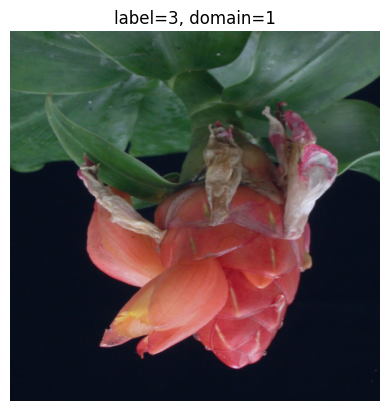

In [ ]:

sample = train_ds[0]
img = sample["image"]
label = sample["label"]
domain = sample["domain"]

plt.imshow(img.permute(1, 2, 0).numpy() * 0.229 + 0.485)  # quick un-normalise-ish
plt.title(f"label={label}, domain={domain}")
plt.axis("off")

# Data Preprocessing

In [ ]:
train_loader = DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True,
)

test_loader = DataLoader(
    test_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True,
)

class_weights = compute_class_weights(train_ds.samples)
class_weights.shape, len(train_loader), len(test_loader)


(torch.Size([100]), 1186, 52)

In [ ]:

# label -> { "herb": [idx], "photo": [idx] }
# build with defaultdict first (convenient)
_label_domain_index_dd = defaultdict(lambda: {"herb": [], "photo": []})

for idx, s in enumerate(train_ds.samples):
    lbl = s["label"]
    dom = s["domain"]  # 0 = herbarium, 1 = photo
    if lbl not in with_set:
        continue
    if dom == 0:
        _label_domain_index_dd[lbl]["herb"].append(idx)
    else:
        _label_domain_index_dd[lbl]["photo"].append(idx)

# keep labels that genuinely have both domains in *train*
with_labels = [
    lbl for lbl in with_set
    if len(_label_domain_index_dd[lbl]["herb"]) > 0
    and len(_label_domain_index_dd[lbl]["photo"]) > 0
]

# convert to a plain dict of lists (no lambdas, safe for DataLoader workers)
label_domain_index = {
    lbl: {
        "herb": list(v["herb"]),
        "photo": list(v["photo"]),
    }
    for lbl, v in _label_domain_index_dd.items()
    if lbl in with_labels
}

len(with_labels), len(label_domain_index), list(with_labels)[:10]

(60, 60, [1, 3, 5, 9, 12, 16, 17, 19, 20, 21])

In [ ]:


class TripletDataset(torch.utils.data.Dataset):
    """
    Samples cross-domain triplets:
      - anchor: herb OR photo
      - positive: same class, other domain
      - negative: different class (any domain)
    Using only with-pair species.
    """
    def __init__(self, base_dataset, label_domain_index, with_labels):
        self.base_dataset = base_dataset
        self.label_domain_index = label_domain_index  # plain dict: lbl -> {"herb": [...], "photo": [...]}
        self.with_labels = list(with_labels)

    def __len__(self):
        # arbitrary; we just want many triplets per epoch
        return len(self.base_dataset)

    def _sample_cross_pair(self):
        lbl = random.choice(self.with_labels)
        dom_anchor = random.choice(["herb", "photo"])
        dom_pos = "photo" if dom_anchor == "herb" else "herb"

        anchor_idx = random.choice(self.label_domain_index[lbl][dom_anchor])
        pos_idx = random.choice(self.label_domain_index[lbl][dom_pos])

        # negative from different class
        neg_lbl = random.choice([l for l in self.with_labels if l != lbl])
        neg_dom = random.choice(["herb", "photo"])
        if len(self.label_domain_index[neg_lbl][neg_dom]) == 0:
            neg_dom = "photo" if neg_dom == "herb" else "herb"
        neg_idx = random.choice(self.label_domain_index[neg_lbl][neg_dom])

        return anchor_idx, pos_idx, neg_idx

    def __getitem__(self, idx):
        a_idx, p_idx, n_idx = self._sample_cross_pair()

        anc = self.base_dataset[a_idx]["image"]
        pos = self.base_dataset[p_idx]["image"]
        neg = self.base_dataset[n_idx]["image"]

        return {
            "anchor": anc,
            "positive": pos,
            "negative": neg,
        }


TRIPLET_BATCH_SIZE = 4

# use fewer workers for triplet loader to avoid heavy startup overhead
TRIPLET_NUM_WORKERS = 0 # you can try 2 later if this is fast

triplet_ds = TripletDataset(train_ds, label_domain_index, with_labels)
triplet_loader = DataLoader(
    triplet_ds,
    batch_size=TRIPLET_BATCH_SIZE,
    shuffle=True,
    num_workers=TRIPLET_NUM_WORKERS,
    pin_memory=True,
)

# warm-up one batch to check shapes
batch = next(iter(triplet_loader))
batch["anchor"].shape, batch["positive"].shape, batch["negative"].shape


(torch.Size([4, 3, 518, 518]),
 torch.Size([4, 3, 518, 518]),
 torch.Size([4, 3, 518, 518]))

# Architecture Setup

In [ ]:


class DinoTriplet(nn.Module):
    def __init__(self, num_classes: int):
        super().__init__()
        self.backbone = timm.create_model(
            "vit_base_patch14_reg4_dinov2.lvd142m",
            pretrained=True,
            num_classes=0,  # embeddings only
        )
        embed_dim = self.backbone.num_features
        self.classifier = nn.Linear(embed_dim, num_classes)

    def forward(self, x, return_embedding=False, normalize_embedding=True):
        feats = self.backbone(x)  # (B, D)
        logits = self.classifier(feats)
        if return_embedding:
            emb = F.normalize(feats, p=2, dim=1) if normalize_embedding else feats
            return logits, emb
        return logits

    def encode(self, x, normalize=True):
        feats = self.backbone(x)
        if normalize:
            return F.normalize(feats, p=2, dim=1)
        return feats


model = DinoTriplet(NUM_CLASSES).to(device)

# --- freezing: same as finetune notebook ---
for p in model.backbone.parameters():
    p.requires_grad = False

n_blocks = len(model.backbone.blocks)
for i in range(n_blocks - 5, n_blocks):
    for p in model.backbone.blocks[i].parameters():
        p.requires_grad = True

for p in model.backbone.norm.parameters():
    p.requires_grad = True

for p in model.classifier.parameters():
    p.requires_grad = True

trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
total = sum(p.numel() for p in model.parameters())
print(f"Trainable params: {trainable/1e6:.2f}M / {total/1e6:.2f}M")

Trainable params: 35.53M / 86.66M


In [ ]:
def get_vit_lr_groups(model, base_lr=1e-4, decay_rate=0.9):
    param_groups = []

    # classifier
    param_groups.append({
        "params": [p for p in model.classifier.parameters() if p.requires_grad],
        "lr": base_lr * 1.0,
        "weight_decay": 1e-4,
    })

    # final norm
    param_groups.append({
        "params": [p for p in model.backbone.norm.parameters() if p.requires_grad],
        "lr": base_lr * 0.9,
        "weight_decay": 1e-4,
    })

    # blocks
    n_blocks = len(model.backbone.blocks)
    for i, block in enumerate(model.backbone.blocks):
        depth = i
        lr_scale = decay_rate ** (n_blocks - depth - 1)
        params = [p for p in block.parameters() if p.requires_grad]
        if not params:
            continue
        param_groups.append({
            "params": params,
            "lr": base_lr * lr_scale,
            "weight_decay": 1e-4,
        })

    # patch_embed (frozen => params list empty)
    patch_params = [p for p in model.backbone.patch_embed.parameters() if p.requires_grad]
    if patch_params:
        param_groups.append({
            "params": patch_params,
            "lr": base_lr * (decay_rate ** n_blocks),
            "weight_decay": 1e-4,
        })

    return param_groups


param_groups = get_vit_lr_groups(model, base_lr=1e-4, decay_rate=0.9)

criterion_ce = nn.CrossEntropyLoss(weight=class_weights.to(device))
criterion_triplet = nn.TripletMarginLoss(margin=0.3, p=2)

scaler = amp.GradScaler(enabled=USE_AMP)

optimizer = torch.optim.AdamW(param_groups)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

for i, g in enumerate(optimizer.param_groups):
    print(f"Group {i}, lr={g['lr']:.8f}, #params={sum(p.numel() for p in g['params'])}")

Group 0, lr=0.00010000, #params=76900
Group 1, lr=0.00009000, #params=1536
Group 2, lr=0.00006561, #params=7089408
Group 3, lr=0.00007290, #params=7089408
Group 4, lr=0.00008100, #params=7089408
Group 5, lr=0.00009000, #params=7089408
Group 6, lr=0.00010000, #params=7089408


C:\Users\William\AppData\Local\Temp\ipykernel_26300\3411212053.py:53: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = amp.GradScaler(enabled=USE_AMP)


In [9]:
@torch.no_grad()
def evaluate_with_split(model, loader, device, with_set, without_set):
    model.eval()

    stats = {
        "all": {"correct1": 0, "correct5": 0, "total": 0},
        "with": {"correct1": 0, "correct5": 0, "total": 0},
        "without": {"correct1": 0, "correct5": 0, "total": 0},
    }

    for batch in loader:
        imgs = batch["image"].to(device, non_blocking=True)
        labels = batch["label"].to(device, non_blocking=True)

        logits = model(imgs)
        probs = logits.softmax(dim=1)

        pred1 = probs.argmax(dim=1)
        top5 = probs.topk(5, dim=1).indices
        match5 = (top5 == labels.unsqueeze(1)).any(dim=1)

        for i in range(labels.size(0)):
            y = labels[i].item()
            p1 = (pred1[i].item() == y)
            p5 = match5[i].item()

            stats["all"]["total"] += 1
            if p1: stats["all"]["correct1"] += 1
            if p5: stats["all"]["correct5"] += 1

            if y in with_set:
                stats["with"]["total"] += 1
                if p1: stats["with"]["correct1"] += 1
                if p5: stats["with"]["correct5"] += 1

            if y in without_set:
                stats["without"]["total"] += 1
                if p1: stats["without"]["correct1"] += 1
                if p5: stats["without"]["correct5"] += 1

    result = {}
    for key, s in stats.items():
        if s["total"] == 0:
            result[key] = {"top1": 0.0, "top5": 0.0, "n": 0}
        else:
            result[key] = {
                "top1": s["correct1"] / s["total"],
                "top5": s["correct5"] / s["total"],
                "n": s["total"],
            }
    return result

In [ ]:

def train_one_epoch_triplet(
    model,
    cls_loader,
    trip_loader,
    optimizer,
    ce_loss_fn,
    triplet_loss_fn,
    lambda_triplet,
    device,
    scaler=None,
    use_amp=False,
):
    model.train()
    running_loss = 0.0
    running_ce = 0.0
    running_trip = 0.0
    correct = 0
    total = 0

    trip_iter = iter(trip_loader)

    for batch in tqdm(cls_loader, desc="Train", leave=False):
        imgs = batch["image"].to(device, non_blocking=True)
        labels = batch["label"].to(device, non_blocking=True)

        try:
            trip_batch = next(trip_iter)
        except StopIteration:
            trip_iter = iter(trip_loader)
            trip_batch = next(trip_iter)

        anc = trip_batch["anchor"].to(device, non_blocking=True)
        pos = trip_batch["positive"].to(device, non_blocking=True)
        neg = trip_batch["negative"].to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)

        with torch.amp.autocast("cuda", enabled=use_amp):
            logits = model(imgs)
            loss_ce = ce_loss_fn(logits, labels)

            anc_emb = model.encode(anc)
            pos_emb = model.encode(pos)
            neg_emb = model.encode(neg)
            loss_trip = triplet_loss_fn(anc_emb, pos_emb, neg_emb)

            loss = loss_ce + lambda_triplet * loss_trip

        if scaler is not None and use_amp:
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            loss.backward()
            optimizer.step()

        running_loss += loss.item() * imgs.size(0)
        running_ce += loss_ce.item() * imgs.size(0)
        running_trip += loss_trip.item() * imgs.size(0)

        preds = logits.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    avg_loss = running_loss / total
    avg_ce = running_ce / total
    avg_trip = running_trip / total
    acc = correct / total
    return avg_loss, acc, avg_ce, avg_trip

# Load Checkpoint

In [11]:
best_ckpt_path = CHECKPOINT_DIR / "best.pt"
ckpt_path = CHECKPOINT_DIR / "epoch_08.pt"

if ckpt_path.exists():
    state = torch.load(ckpt_path, map_location=device)
    model.load_state_dict(state["model_state"])
    optimizer.load_state_dict(state["optimizer_state"])
    scheduler.load_state_dict(state["scheduler_state"])
    history = state.get("history", [])
    start_epoch = state["epoch"] + 1
    print("Resuming from epoch", start_epoch)
else:
    print(f"No checkpoint found at {ckpt_path}. Skipping resume.")
    history = []
    start_epoch = 1

No checkpoint found at c:\Users\William\School\Swinburne\Computer Science\2025 Semester 2\COS30082 Applied Machine Learning\Assignment 2\Approach3\experiments\triplet\checkpoints\epoch_08.pt. Skipping resume.


In [ ]:
history_path = CHECKPOINT_DIR / "history_triplet.json"
with open(history_path, "w", encoding="utf-8") as f:
    json.dump(history, f, indent=2)
history_path

WindowsPath('c:/Users/William/School/Swinburne/Computer Science/2025 Semester 2/COS30082 Applied Machine Learning/Assignment 2/Approach3/experiments/triplet/checkpoints/history_triplet.json')

# Model Training

In [ ]:


EPOCHS = 10
if "history" not in globals():
    history = []

# don't overwrite best_top1 if loaded
if "best_top1" not in globals():
    best_top1 = 0.0

for epoch in range(start_epoch, EPOCHS + 1):
    start = time.time()

    train_loss, train_acc, ce_loss, trip_loss = train_one_epoch_triplet(
        model,
        train_loader,
        triplet_loader,
        optimizer,
        criterion_ce,
        criterion_triplet,
        LAMBDA_TRIPLET,
        device,
        scaler=scaler,
        use_amp=USE_AMP,
    )

    eval_stats = evaluate_with_split(model, test_loader, device, with_set, without_set)
    top1 = eval_stats["all"]["top1"]
    top5 = eval_stats["all"]["top5"]

    elapsed = time.time() - start

    history.append(
        dict(
            epoch=epoch,
            train_loss=train_loss,
            train_acc=train_acc,
            ce_loss=ce_loss,
            triplet_loss=trip_loss,
            test_top1_all=eval_stats["all"]["top1"],
            test_top5_all=eval_stats["all"]["top5"],
            test_top1_with=eval_stats["with"]["top1"],
            test_top5_with=eval_stats["with"]["top5"],
            test_top1_without=eval_stats["without"]["top1"],
            test_top5_without=eval_stats["without"]["top5"],
            epoch_time_sec=elapsed,
        )
    )

    # save epoch checkpoint
    epoch_ckpt = CHECKPOINT_DIR / f"epoch_{epoch:02d}.pt"
    torch.save(
        {
            "epoch": epoch,
            "model_state": model.state_dict(),
            "optimizer_state": optimizer.state_dict(),
            "scheduler_state": scheduler.state_dict(),
            "history": history,
        },
        epoch_ckpt,
    )

    # update best
    if top1 >= best_top1:
        best_top1 = top1
        torch.save(
            {
                "epoch": epoch,
                "model_state": model.state_dict(),
                "optimizer_state": optimizer.state_dict(),
                "scheduler_state": scheduler.state_dict(),
                "history": history,
                "best_top1": best_top1,
            },
            best_ckpt_path,
        )

    scheduler.step()

    print(
        f"Epoch {epoch:02d} | "
        f"train_loss={train_loss:.4f} "
        f"train_acc={train_acc:.3f} | "
        f"CE={ce_loss:.4f} TRIP={trip_loss:.4f} | "
        f"ALL top1={eval_stats['all']['top1']:.3f} "
        f"ALL top5={eval_stats['all']['top5']:.3f} | "
        f"W/PAIR top1={eval_stats['with']['top1']:.3f} "
        f"W/O-PAIR top1={eval_stats['without']['top1']:.3f} | "
        f"time={elapsed:.1f}s"
    )

best_top1, max(h["test_top5_all"] for h in history)

Train:   0%|          | 0/1186 [00:08<?, ?it/s]

C:\Users\William\AppData\Local\Temp\ipykernel_26300\882667834.py:41: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


Epoch 01 | train_loss=2.1647 train_acc=0.498 | CE=2.1108 TRIP=0.1077 | ALL top1=0.599 ALL top5=0.792 | W/PAIR top1=0.771 W/O-PAIR top1=0.111 | time=942.1s


Train:   0%|          | 0/1186 [00:08<?, ?it/s]

Epoch 02 | train_loss=0.7264 train_acc=0.808 | CE=0.7055 TRIP=0.0417 | ALL top1=0.676 ALL top5=0.865 | W/PAIR top1=0.856 W/O-PAIR top1=0.167 | time=938.1s


Train:   0%|          | 0/1186 [00:08<?, ?it/s]

Epoch 03 | train_loss=0.3572 train_acc=0.905 | CE=0.3467 TRIP=0.0211 | ALL top1=0.647 ALL top5=0.845 | W/PAIR top1=0.804 W/O-PAIR top1=0.204 | time=938.3s


Train:   0%|          | 0/1186 [00:08<?, ?it/s]

Epoch 04 | train_loss=0.1945 train_acc=0.943 | CE=0.1871 TRIP=0.0148 | ALL top1=0.696 ALL top5=0.831 | W/PAIR top1=0.889 W/O-PAIR top1=0.148 | time=939.8s


Train:   0%|          | 0/1186 [00:08<?, ?it/s]

Epoch 05 | train_loss=0.0903 train_acc=0.975 | CE=0.0864 TRIP=0.0078 | ALL top1=0.754 ALL top5=0.855 | W/PAIR top1=0.948 W/O-PAIR top1=0.204 | time=983.1s


Train:   0%|          | 0/1186 [00:09<?, ?it/s]

Epoch 06 | train_loss=0.0429 train_acc=0.990 | CE=0.0409 TRIP=0.0040 | ALL top1=0.725 ALL top5=0.845 | W/PAIR top1=0.915 W/O-PAIR top1=0.185 | time=952.7s


Train:   0%|          | 0/1186 [00:09<?, ?it/s]

Epoch 07 | train_loss=0.0167 train_acc=0.996 | CE=0.0155 TRIP=0.0025 | ALL top1=0.744 ALL top5=0.845 | W/PAIR top1=0.935 W/O-PAIR top1=0.204 | time=955.2s


Train:   0%|          | 0/1186 [00:10<?, ?it/s]

Epoch 08 | train_loss=0.0118 train_acc=0.998 | CE=0.0110 TRIP=0.0015 | ALL top1=0.749 ALL top5=0.860 | W/PAIR top1=0.948 W/O-PAIR top1=0.185 | time=958.6s


Train:   0%|          | 0/1186 [00:09<?, ?it/s]

Epoch 09 | train_loss=0.0043 train_acc=0.999 | CE=0.0038 TRIP=0.0010 | ALL top1=0.763 ALL top5=0.860 | W/PAIR top1=0.961 W/O-PAIR top1=0.204 | time=961.1s


KeyboardInterrupt: 